# EigenCAM for HRNet

In [121]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import sys
sys.path.append("/home/gruppo9/OnlineKD-HRNet-Human-Pose-Estimation-GradCAM")
sys.path.append("/home/gruppo9/OnlineKD-HRNet-Human-Pose-Estimation-GradCAM/lib")
sys.path.append("/home/gruppo9/OnlineKD-HRNet-Human-Pose-Estimation-GradCAM/models")
import os
import cv2
import torch    
import shutil
import numpy as np
import torchvision.transforms as transforms

from PIL import Image
from lib import models
from pytorch_grad_cam import EigenCAM
from pytorch_grad_cam import GuidedBackpropReLUModel

from lib.config.default_nb import _C as cfg, update_config
from pytorch_grad_cam.utils.image import show_cam_on_image, scale_cam_image, deprocess_image, preprocess_image


COLORS = np.random.uniform(0, 255, size=(80, 3))

# selezione del modello
# ES: 
# cfg_file = "/home/gruppo9/OnlineKD-HRNet-Human-Pose-Estimation-GradCAM/experiments/babypose/hrnet/4_stage_coco_lr_7-5e-4.yaml"
# cfg_file = "/home/gruppo9/OnlineKD-HRNet-Human-Pose-Estimation-EigenCAM/experiments/babypose/hrnet/coco.yaml"  #per l'utilizzo del modello addestrato su COCO
cfg_file = ""

update_config(cfg, cfg_file)

Calcolo delle predizioni utilizzando il modello addestrato su babypose

In [122]:
# inserire path dell'immagine 
# ES:
# img = cv2.imread('/home/gruppo9/OnlineKD-HRNet-Human-Pose-Estimation-GradCAM/data/babypose/images/train/000000010496.png')  
img = cv2.imread('')

img = cv2.resize(img, (192, 256))
img = np.float32(img) / 255
transform = transforms.ToTensor()
tensor = transform(img).unsqueeze(0)

from models import multi_out_pose_hrnet
model = eval(cfg.MODEL.NAME+'.get_pose_net')(cfg, is_train=False)
model.load_state_dict(torch.load(cfg.TEST.MODEL_FILE), strict=False)

outputs = model(tensor)[-1] #output del quarto stage
# outputs = model(tensor)[-2] #output del terzo stage
outputs = outputs.squeeze(dim=0)
image = img * 255

colors = [
    (255, 0, 0),   # blu per braccio destro
    (0, 255, 0),   # verde per braccio sinistro
    (0, 0, 255),   # rosso per gamba destra
    (0, 255, 255)  # giallo per gamba sinistra
]

# gruppi_articolazioni = {
#     'braccio_destro': [0, 1, 2],
#     'braccio_sinistro': [3, 4, 5],
#     'gamba_destra': [6, 7, 8],
#     'gamba_sinistra': [9, 10, 11]
# }


for idx, output in enumerate(outputs):
    pos = (output==torch.max(output)).nonzero()
    coords = pos[0]
    y = coords.detach().cpu().numpy()[0]*256/64
    x = coords.detach().cpu().numpy()[1]*192/48
    limb_idx = idx // 3  # calcola l'indice del gruppo di articolazioni (ciascun arto ha 3 articolazioni)
    color = colors[limb_idx]
    image = cv2.circle(image, (int(x),int(y)), radius=2, color=color, thickness=-1)

# inserire path di output per le predizioni
# ES:
# preds_output_path = os.path.join('/home/gruppo9/OnlineKD-HRNet-Human-Pose-Estimation-GradCAM/output', 'preds')
preds_output_path = os.path.join('')

cv2.imwrite(preds_output_path, image)

True

Calcolo delle predizioni utilizzando il modello addestrato su COCO

In [ ]:
# # inserire path dell'immagine 
# # ES:
# # img = cv2.imread('/home/gruppo9/OnlineKD-HRNet-Human-Pose-Estimation-GradCAM/data/babypose/images/train/000000010496.png')  
# img = cv2.imread('')

# img = cv2.resize(img, (192, 256))
# img = np.float32(img) / 255
# transform = transforms.ToTensor()
# tensor = transform(img).unsqueeze(0)

# from models import multi_out_pose_hrnet
# model = eval(cfg.MODEL.NAME+'.get_pose_net')(cfg, is_train=False)
# model.load_state_dict(torch.load(cfg.TEST.MODEL_FILE), strict=False)

# outputs = model(tensor)[-1] #output del quarto stage
# # outputs = model(tensor)[-2] #output del terzo stage
# outputs = outputs.squeeze(dim=0)
# image = img * 255

# colors = [
#     (255, 0, 0),   # blu 
#     (0, 255, 0),   # verde
#     (0, 0, 255),   # rosso 
#     (0, 255, 255),  # giallo 
#     (100,100,200),
#     (255,255,0),
#     (255,0,255)]
    
# for idx, output in enumerate(outputs):
#     pos = (output==torch.max(output)).nonzero()
#     coords = pos[0]
#     y = coords.detach().cpu().numpy()[0]*256/64
#     x = coords.detach().cpu().numpy()[1]*192/48
    
#     if idx == 0:
#         color = colors[0]
#     elif idx == 1 or idx == 2:
#         color = colors[1]
#     elif idx == 3 or idx == 4:
#         color = colors[2]
#     elif idx == 6 or idx == 8 or idx == 10:
#         color = colors[3]
#     elif idx == 5 or idx == 7 or idx == 9:
#         color = colors[4]
#     elif idx == 11 or idx == 13 or idx == 15:
#         color = colors[5]
#     else:
#         color = colors[6]
    
#     image = cv2.circle(image, (int(x),int(y)), radius=2, color=color, thickness=-1)

# # inserire path di output per le predizioni
# # ES:
# # preds_output_path = os.path.join('/home/gruppo9/OnlineKD-HRNet-Human-Pose-Estimation-GradCAM/output', 'preds')
# preds_output_path = os.path.join('')

# cv2.imwrite(preds_output_path, image)

Stampa del modello

In [124]:
print(model)

Visualizzazione dell'output di EigenCAM nell'ultima convoluzione del quarto stage

In [126]:
target_layers = [model.stage4[-1].branches[0][-1].conv2]
cam = EigenCAM(model, target_layers)#, use_cuda=False)
grayscale_cam = cam(tensor)[0, :]
cam_image = show_cam_on_image(img, grayscale_cam, use_rgb=True)

# inserire path di output e nome immagine per la mappa EigenCAM
# ES:
# cam_output_path = os.path.join('/home/gruppo9/OnlineKD-HRNet-Human-Pose-Estimation-GradCAM/output', '_conv_layer_4stage.jpg')
cam_output_path = os.path.join('', '')

cv2.imwrite(cam_output_path, cv2.cvtColor(cam_image, cv2.COLOR_RGB2BGR))
Image.fromarray(cam_image)

Visualizzazione dell'output di EigenCAM nel fuse layer del quarto stage

In [128]:
target_layers = [model.stage4[-1].fuse_layers[0][1]]
cam = EigenCAM(model, target_layers)#, use_cuda=False)
grayscale_cam = cam(tensor)[0, :]
cam_image = show_cam_on_image(img, grayscale_cam, use_rgb=True)

# inserire path di output e nome dell'immagine per le predizioni
# ES:
# cam_output_path = os.path.join('/home/gruppo9/OnlineKD-HRNet-Human-Pose-Estimation-GradCAM/output', '_fuse_layer.jpg')
cam_output_path = os.path.join('', '')

cv2.imwrite(cam_output_path, cv2.cvtColor(cam_image, cv2.COLOR_RGB2BGR))
Image.fromarray(cam_image)

Visualizzazione dell'output di EigenCAM nel layer di output del terzo stage

In [129]:
target_layers = [model.intermediate_layers[2]] #output stage3
cam = EigenCAM(model, target_layers)#, use_cuda=False)
grayscale_cam = cam(tensor)[0, :]
cam_image = show_cam_on_image(img, grayscale_cam, use_rgb=True)

# inserire path di output e nome dell'immagine per le predizioni
# ES:
# cam_output_path = os.path.join('/home/gruppo9/OnlineKD-HRNet-Human-Pose-Estimation-GradCAM/output', '_output_3stage.jpg')
cam_output_path = os.path.join('', '')

cv2.imwrite(cam_output_path, cv2.cvtColor(cam_image, cv2.COLOR_RGB2BGR))
Image.fromarray(cam_image)

Visualizzazione dell'output di EigenCAM nel layer di output del quarto stage

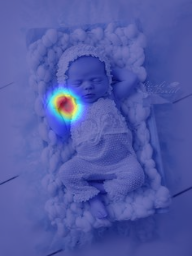

In [130]:
target_layers = [model.final_layer]
cam = EigenCAM(model, target_layers)#, use_cuda=False)
grayscale_cam = cam(tensor)[0, :]
cam_image = show_cam_on_image(img, grayscale_cam, use_rgb=True)

# inserire path di output e nome dell'immagine per le predizioni
# ES:
# cam_output_path = os.path.join('/home/gruppo9/OnlineKD-HRNet-Human-Pose-Estimation-GradCAM/output', '_output_4stage.jpg')
cam_output_path = os.path.join('', '')

cv2.imwrite(cam_output_path, cv2.cvtColor(cam_image, cv2.COLOR_RGB2BGR))
Image.fromarray(cam_image)